# Useful links-
https://www.kaggle.com/code/rkuo2000/tiny-nerf
https://krrish94.github.io/
https://colab.research.google.com/drive/1rO8xo0TemN67d4mTpakrKrLp03b9bgCX#scrollTo=EHNwlsOT7NTp
https://github.com/krrish94/nerf-pytorch?tab=readme-ov-file
https://www.google.com/search?q=nerf+github+pytorch&sca_esv=90675d82984edeb9&ei=tp_GZZ-tN7jakPIP5uenmAI&ved=0ahUKEwif4LKUoJ-EAxU4LUQIHebzCSMQ4dUDCBA&uact=5&oq=nerf+github+pytorch&gs_lp=Egxnd3Mtd2l6LXNlcnAiE25lcmYgZ2l0aHViIHB5dG9yY2gyBRAAGIAESIgYUNQCWMoQcAF4AZABAJgBjQGgAYcGqgEDNy4xuAEDyAEA-AEBwgIKEAAYRxjWBBiwA8ICDRAAGIAEGIoFGEMYsAPCAgYQABgWGB7iAwQYACBBiAYBkAYK&sclient=gws-wiz-serp
https://autonomousvision.github.io/differentiable-volumetric-rendering/
https://computergraphics.stackexchange.com/questions/1769/world-coordinates-normalised-device-coordinates-and-device-coordinates
https://freedium.cfd/https://towardsdatascience.com/its-nerf-from-nothing-build-a-vanilla-nerf-with-pytorch-7846e4c45666
https://pytorch3d.org/docs/cameras
https://arxiv.org/pdf/2003.08934.pdf

# Doubts to check-
1. why sinusoidal for positional encoding
2. more on why positional encoding
3. what is density information
4. diff between tiny nerf and nerf
5. why scale randomly sampled query points
6. check on coord transformations more in CG


1. why ndc
2. why norm only view directions
3. why concat in rays
4. why far =1

# Project ideas-
1. https://arxiv.org/html/2312.02751v2

# Todos-
1. play with near and far values
2. far-near sampling



In [ ]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# Other globals
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

--2024-02-24 22:13:57--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-02-24 22:13:57--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  36.6MB/s    in 0.3s    

2024-02-24 22:13:57 (36.6 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



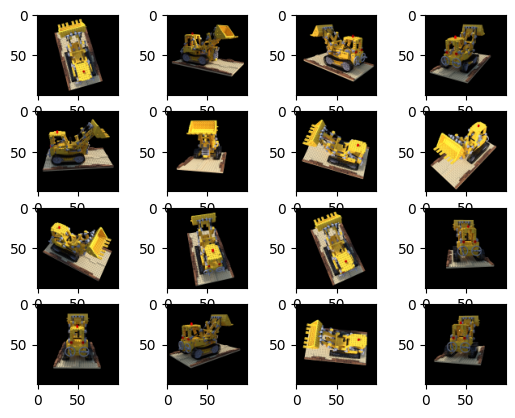

In [ ]:
# Load dataset
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
data = np.load('tiny_nerf_data.npz')

# Visualize images in dataset
num_images = data['images'].shape[0]
random_indices = np.random.choice(num_images, size=16, replace=False)
fig = plt.figure()
for i in range(1, len(random_indices)+1):
  fig.add_subplot(4,4,i)
  plt.imshow(data["images"][random_indices[i-1]])

In [ ]:
# Convert data to tensors

# Hold one image for test
images = data['images']
test_image = images[101]
test_image = torch.from_numpy(test_image).to(device)
images = torch.from_numpy(images[:100,]).to(device)

poses = data['poses']
poses = torch.from_numpy(poses).to(device)
test_pose = poses[101]

focal_length = data['focal']
focal_length = torch.from_numpy(focal_length).to(device)

height, width = images.shape[1:3] # TODO: isn't it width, height?

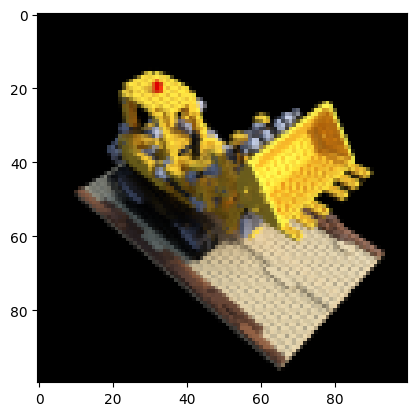

In [ ]:
# Visualize test image
plt.imshow(test_image.detach().cpu().numpy())

In [ ]:
# Compute directions and origins for rays for all pixels in the image.
# Both will be of shape  h x w x 3
def get_raybundle_for_img(height: int, width: int, focal_length: float, tf_cam2world: torch.Tensor):

  # Create a meshgrid for the image pixels
  pixel_coors_along_w = torch.arange(width)
  pixel_coors_along_h = torch.arange(height)
  wcoor_grid_pixel = pixel_coors_along_w.expand(height,-1).to(device)
  hcoor_grid_pixel = pixel_coors_along_h.view(-1,1).expand(-1, width).to(device)

  # Compute ray directions extending from optical center to 3d world for every pixel.
  # This is basically expressing pixel coordinates in world frame.
  wcoor_grid_cam = (wcoor_grid_pixel - (width/2))/ focal_length
  hcoor_grid_cam = -1*(hcoor_grid_pixel - (height/2))/ focal_length
  pixel_coors_cam = torch.stack([wcoor_grid_cam, hcoor_grid_cam, -torch.ones_like(wcoor_grid_cam)], dim=-1)

  # To convert cam to world frame, 3x3 rotation matrix of pose must be multiplied by column vector of each point.
  # We have hxwx3 matrix. Write down the multiplication for one element and you'll know how to implement it.
  pixel_coors_world = torch.sum(pixel_coors_cam[..., None, :] * tf_cam2world[:3, :3], dim=-1)
  ray_directions_world = pixel_coors_world

  ray_origins_world = tf_cam2world[:3,-1].expand(pixel_coors_world.shape)

  return ray_origins_world, ray_directions_world

In [ ]:
# Sample 3D points and their depth values on the ray bundle
# sampled 3d points will be of shape h x w x num_samples x 3 and depth_values will be of shape h x w x num_samples
def sample_ray_bundle(ray_directions_world: torch.Tensor, ray_origins_world: torch.Tensor, nearThresh: float, farThresh: float, num_points: int):
  depth_values = torch.linspace(nearThresh, farThresh, num_points).to(device) # (num_points)

  # Randomize depth values
  noise_shape = list(ray_origins_world.shape[:-1])+[num_points]
  depth_values = depth_values + torch.rand(noise_shape).to(device) * (farThresh-nearThresh)/num_points # (h x w x num_points)

  sample_points = ray_origins_world[...,None,:] + (ray_directions_world[...,None,:] * depth_values[...,:,None])
  return depth_values, sample_points

  # Todo: add explanation for below
  # 1 broadcasting- multiply depth_value to x,y,z ---- ray_direction(hxwx3) * depth_values[0x1]
  # 2 braodcasting- multiply each point in ray_directions to depth_values ----- ray
  # hxwx1x3, num_points -> hxwxnum_pointsx3

In [ ]:
# Perform positional encoding on a tensor to get a high-dimensional representation enabling better capture of high frequency variations and
# to capture the relationship between tensor values.
# encoding is of shape (h * w * num_samples, 3 +(2 * num_encoding_functions * 3))
def positional_encoding(tensor: torch.Tensor, num_encoding_functions: int):
  encoding = tensor # (h * w * num_samples, 3)

  # if no positional encoding is done
  if num_encoding_functions == 0:
    return encoding

  # if positional encoding is done
  else:
    frequency_band = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
    )
    for frequency in frequency_band:
      for func in [torch.sin, torch.cos]:
        sinusoidal_component = func(tensor * frequency)
        encoding = torch.cat([encoding, sinusoidal_component], dim=-1)
    return encoding

In [ ]:
# Define model architecture.
# Input is of shape - (h * w * num_samples, 3 +(2 * num_encoding_functions * 3))
# Output is of shape - (h * w * num_samples, 4) where the 4-dim vector represents the RGB information and density of that respective 3D sample point.
class tinyNerf(nn.Module):
  def __init__(self, num_encoding_functions: int, filter_size=128):
    super(tinyNerf, self).__init__()
    self.fc1 = nn.Linear(3 +(2 * num_encoding_functions * 3), filter_size)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(filter_size, filter_size)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(filter_size, 4)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    return x

In [ ]:
# Input is of shape (h x w x num_samples x 4)
# Output is of shape (h x w x 3)
# TODO: Add diagramatic explanation for understanding
def render_image_from_3dinfo(rgb_density: torch.Tensor, depth_values: torch.Tensor):

  # Normalize RGB values to the range 0 to 1 and since density (opacity/ amount of light absorbed/ absorption coeff) is non-negative, apply relu activation.
  rgb_values = torch.sigmoid(rgb_density[..., :3]) # (h x w x num_samples x 3)
  density_values = torch.nn.functional.relu(rgb_density[..., 3])

  # Compute consecutive difference between depth values, i.e distance of every segment sampled in 3D space
  dist_values = depth_values[...,1:]-depth_values[...,:-1]

  # For the last segment i.e between the last sampled point and ray end, distance is unbounded. So to make it tractable, we add last segment distance to a large value.
  one_e10 = torch.tensor([1e10], dtype=depth_values.dtype, device=depth_values.device).expand(depth_values[..., :1].shape)
  dist_values = torch.cat([dist_values, one_e10], dim=-1) # (h x w x num_samples)

  # Compute cumulative transmittance along every segment (complement of absorption, i.e amount of light trasmitted through medium after absorption)
  transmittance_values = 1. - torch.exp(-density_values * dist_values)
  num_stability_val = 1e-10
  cum_transmittance_values = transmittance_values * cumprod_exclusive(1. - transmittance_values + num_stability_val) # (h x w x num_samples)
  # TODO: why 1-transmittance values

  # Render RGB map i.e RGB image
  rgb_map = (cum_transmittance_values[..., None] * rgb_values).sum(dim=-2) # (h x w x 3)

  # Render depth map i.e. depth image
  depth_map = (cum_transmittance_values * depth_values).sum(dim=-1) # (h x w x 1)

  # Compute cum trasnmittance for image
  accumulated_transmittance_map = cum_transmittance_values.sum(dim=-1)

  return rgb_map



In [ ]:
def cumprod_exclusive(tensor: torch.Tensor):

  # for input (a,b,c), cumprod_inclusive is (a, a*b, a*b*c)
  cumprod_inclusive = torch.cumprod(tensor, dim=-1)

  # for input (a,b,c), cumprod_exclusive is (1, a, a*b)
  cumprod_exclusive = torch.roll(cumprod_inclusive, 1, dims=-1) # (a*b*c, a, a*b)
  cumprod_exclusive[..., 0] = 1.

  return cumprod_exclusive

In [ ]:
def get_chunks(tensor: torch.Tensor, chunk_size: int):
  chunks = [tensor[i:i+chunk_size] for i in range(0, tensor.shape[0], chunk_size)]
  return chunks

In [ ]:
# Define forward propagation of tinyNerf
def run_tinyNerf(height: int, width: int, focal_length: float, training_campose: torch.Tensor,
                  near_thresh: float, far_thresh: float, num_samples_per_ray:int,
                  num_encoding_functions: int, model, chunk_size: int):
  ray_origins_world, ray_directions_world = get_raybundle_for_img(height, width, focal_length, training_campose)

  depth_values, sample_points = sample_ray_bundle(ray_directions_world, ray_origins_world, near_thresh, far_thresh, num_samples_per_ray)

  flattened_sample_points = sample_points.view(-1,3)
  encoded_sample_points = positional_encoding(flattened_sample_points, num_encoding_functions) # (h * w * num_samples, 3 +(2 * num_encoding_functions * 3))

  chunks = get_chunks(encoded_sample_points, chunk_size)
  predictions = []
  for chunk in chunks:
    predictions.append(model(chunk.to(device)))
  rgb_density_for_sample_points = torch.cat(predictions, dim=0) # (h*w*num_samples, 4)
  rgb_density_for_sample_points = rgb_density_for_sample_points.view(height, width, num_samples_per_ray, 4)

  predicted_img = render_image_from_3dinfo(rgb_density_for_sample_points, depth_values)
  return predicted_img

  0%|          | 0/2000 [00:00<?, ?it/s]

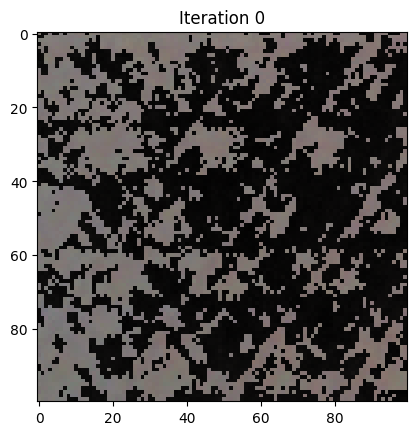

  5%|▍         | 98/2000 [00:04<01:15, 25.22it/s]

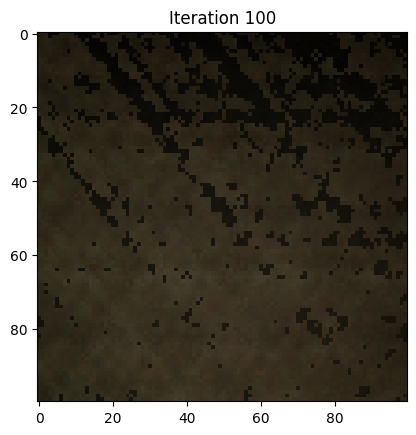

 10%|█         | 200/2000 [00:08<01:10, 25.42it/s]

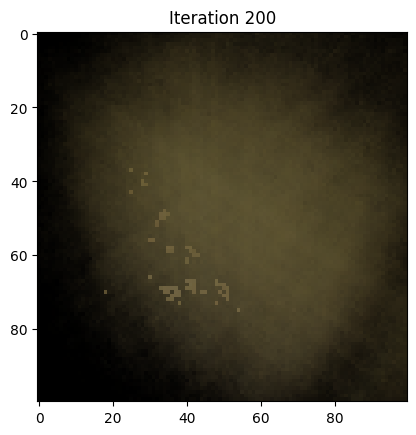

 15%|█▍        | 299/2000 [00:13<01:10, 24.13it/s]

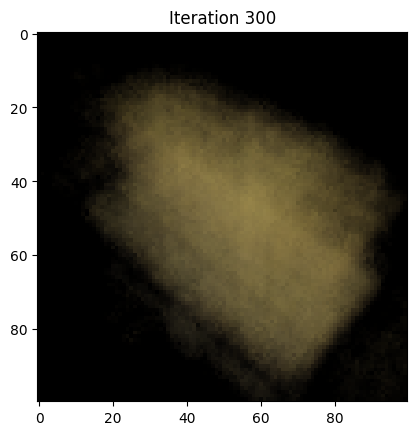

 20%|█▉        | 398/2000 [00:17<01:01, 26.00it/s]

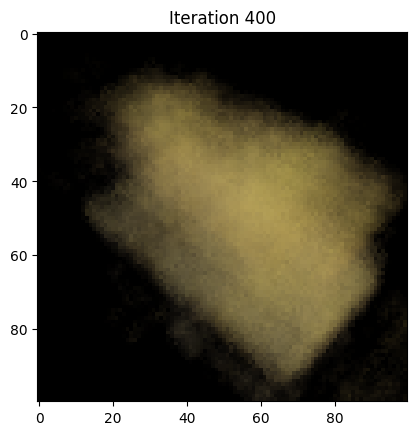

 25%|██▌       | 500/2000 [00:21<00:57, 26.09it/s]

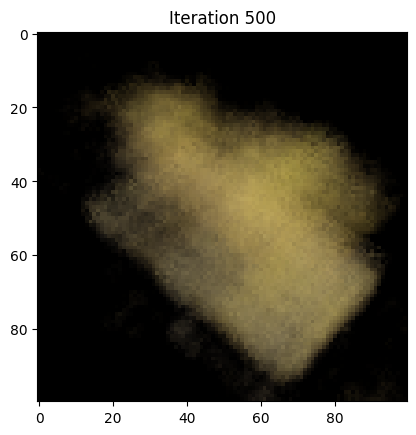

 30%|██▉       | 599/2000 [00:25<00:55, 25.20it/s]

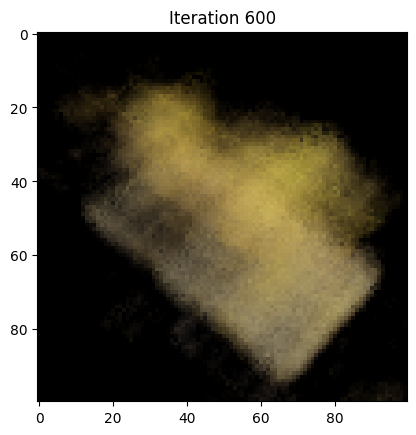

 35%|███▍      | 698/2000 [00:29<00:50, 25.86it/s]

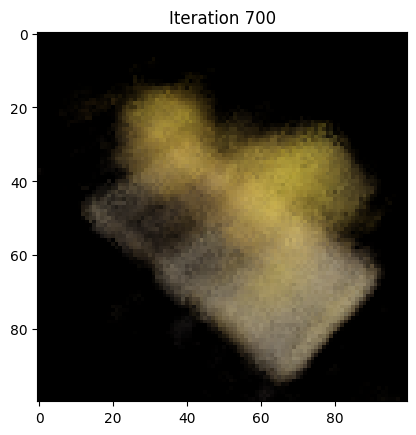

 40%|████      | 800/2000 [00:33<00:46, 25.99it/s]

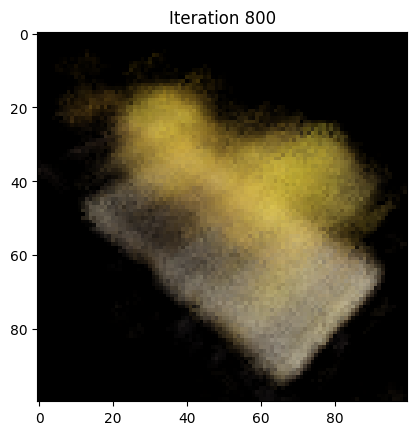

 45%|████▍     | 899/2000 [00:37<00:43, 25.55it/s]

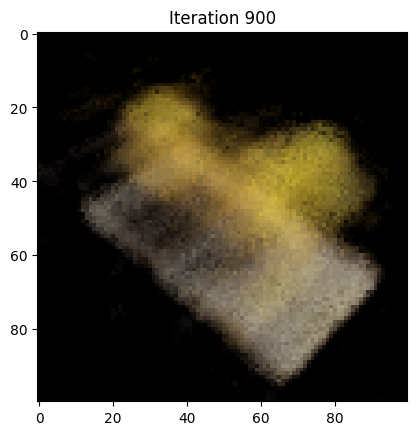

 50%|████▉     | 998/2000 [00:41<00:38, 26.09it/s]

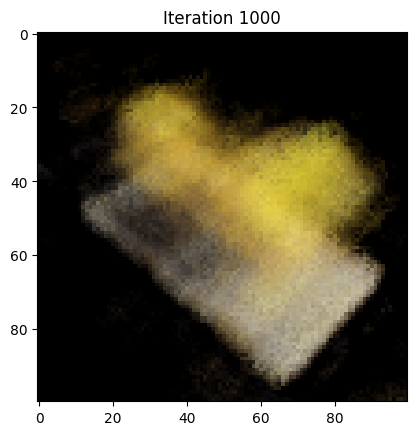

 55%|█████▌    | 1100/2000 [00:45<00:34, 25.75it/s]

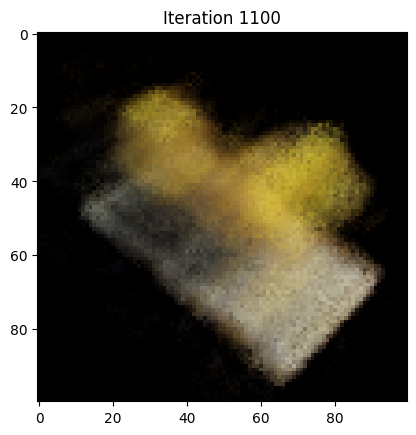

 60%|█████▉    | 1199/2000 [00:49<00:31, 25.65it/s]

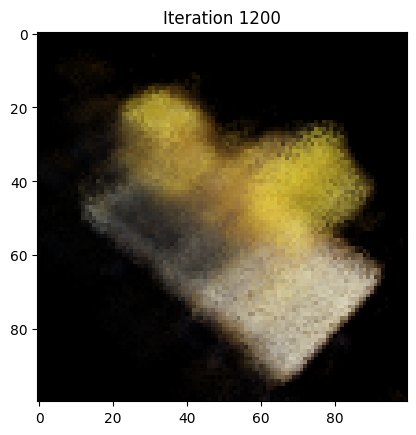

 65%|██████▍   | 1298/2000 [00:54<00:27, 25.54it/s]

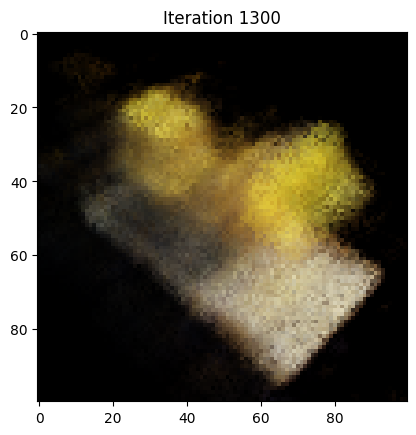

 70%|███████   | 1400/2000 [00:58<00:23, 25.72it/s]

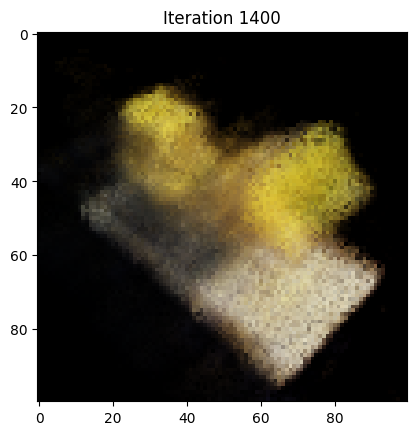

 75%|███████▍  | 1499/2000 [01:02<00:19, 25.74it/s]

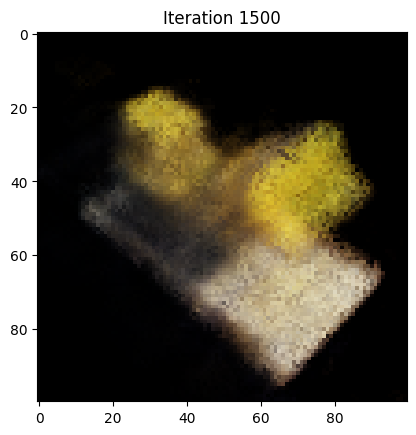

 80%|███████▉  | 1598/2000 [01:06<00:15, 25.60it/s]

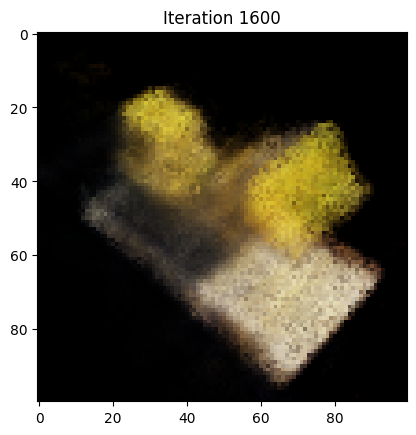

 85%|████████▌ | 1700/2000 [01:10<00:11, 25.73it/s]

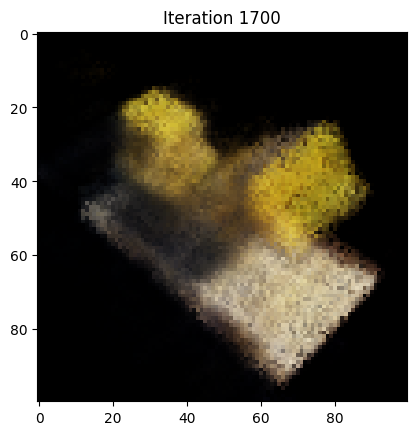

 90%|████████▉ | 1799/2000 [01:15<00:07, 25.75it/s]

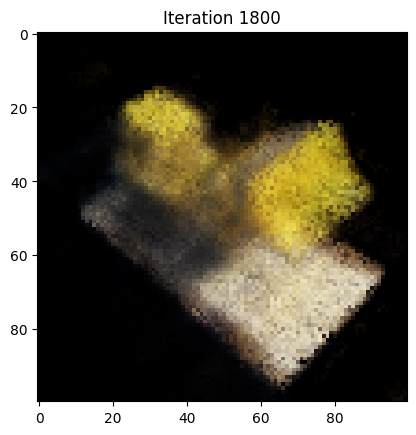

 95%|█████████▍| 1898/2000 [01:19<00:03, 25.61it/s]

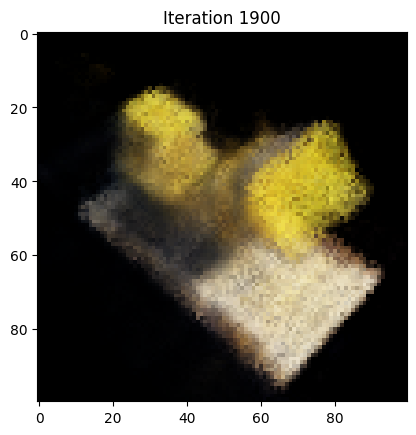

100%|██████████| 2000/2000 [01:23<00:00, 23.92it/s]


In [ ]:
# Training module

num_encoding_functions = 6
near_thresh = 2.
far_thresh = 6.
num_samples_per_ray = 32

num_epochs = 2000
batch_size = 1 # TODO: why not have more images in batch
chunk_size = 12288 # because 4096 for 1.2GB of GPU memory

model = tinyNerf(num_encoding_functions=num_encoding_functions).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in tqdm(range(num_epochs)):
  model.train()

  # Pick one random sample for training
  index = np.random.randint(len(images))
  target_img = images[index].to(device)
  training_campose = poses[index].to(device)

  # Call tinyNerf- # TODO
  predicted_img = run_tinyNerf(height, width, focal_length, training_campose,
                               near_thresh, far_thresh, num_samples_per_ray,
                               num_encoding_functions, model, chunk_size)

  # Compute loss
  loss = torch.nn.functional.mse_loss(predicted_img, target_img)

  # Backpropagate
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Evaluation for every few epochs on test pose
  if epoch % 100 ==0:
    model.eval()
    predicted_test_img = run_tinyNerf(height, width, focal_length, test_pose,
                               near_thresh, far_thresh, num_samples_per_ray,
                               num_encoding_functions, model, chunk_size)
    fig = plt.figure()
    plt.imshow(predicted_test_img.detach().cpu().numpy())
    plt.title(f"Iteration {epoch}")
    plt.show()